In [ ]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):   # This basically allows us to print nicer looking expressions for the final output
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d= e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

In [8]:
from graphviz import Digraph

def trace(root):
    #Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR == Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #For any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % ( n.label, n.data, n.grad), shape='record')
        if n._op:
            #If this value is a result of some operation, then create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #Connect n1 to the node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

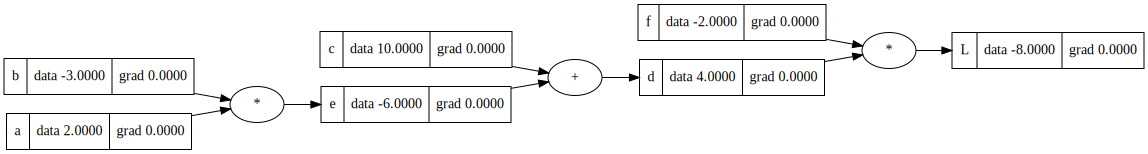

In [ ]:
draw_dot(L)

------------------

### **Implementing the Neuron Mathematical Mode**

![Neuron Model](https://imgs.search.brave.com/eGlTokdhbINxZOKkAUnAz_Cu-grWMt7LkMKJoi66gdQ/rs:fit:500:0:0:0/g:ce/aHR0cHM6Ly9jczIz/MW4uZ2l0aHViLmlv/L2Fzc2V0cy9ubjEv/bmV1cm9uX21vZGVs/LmpwZWc)

In [ ]:
#Inputs x1, x2 of the neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#Weights w1, w2 of the neuron - The synaptic values
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#The bias of the neuron
b = Value(6.7, label='b')

In [ ]:
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

#The summation
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

In [ ]:
#n is basically the cell body, but without the activation function
n = x1w1x2w2 + b; n.label = 'n'

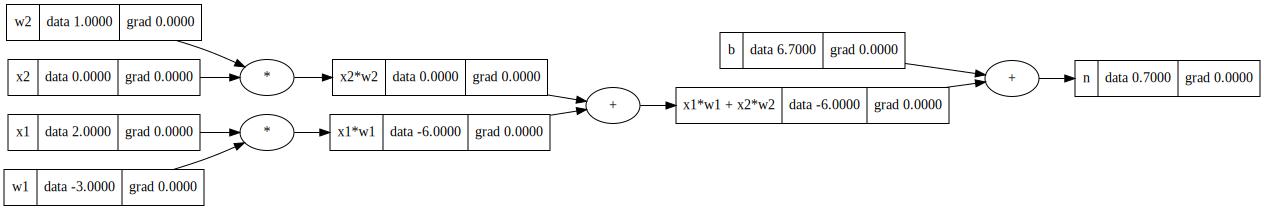

In [ ]:
draw_dot(n)

Now, we have to get the output i.e. by having the dot product with the activation function.

So we have to implement the tanh function

Now, tanh is a hyperbolic expression. So it doesnt just contain +, -, it also has exponetials. So we have to create that function first in our Value object.

&nbsp;

![tanh equation](https://wikimedia.org/api/rest_v1/media/math/render/svg/b8dc4c309a551cafc2ce5c883c924ecd87664b0f)


So now, lets update our Value object

In [4]:
import math

In [1]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):   # This basically allows us to print nicer looking expressions for the final output
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out

In [2]:
#Inputs x1, x2 of the neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#Weights w1, w2 of the neuron - The synaptic values
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#The bias of the neuron
b = Value(6.7, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

#The summation
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

In [ ]:
#n is basically the cell body, but without the activation function
n = x1w1x2w2 + b; n.label = 'n'

#Now we pass n to the activation function

o = n.tanh(); o.label = 'o'

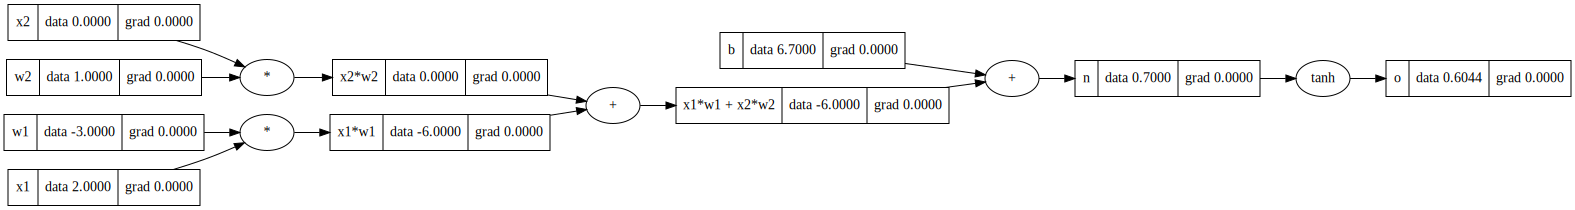

In [ ]:
draw_dot(o)

We have recieved that output. So now, tanh is our little 'micrograd supported' node here, as an operation :)

------------------

We'll be doing the manual backpropagation calculation now

In [30]:
x1 = Value(0.0, label='x1')
x2 = Value(2.0, label='x2')

w1 = Value(1.0, label='w1')
w2 = Value(-3.0, label='w2')

b = Value(6.8813735870195432, label='b')  #We've set this specific value for calculation purposes. Normally, if you increase this value, the final ouput will close to one.

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

First we know the derivative of o wrt o will be 1, so

In [31]:
o.grad = 1.0

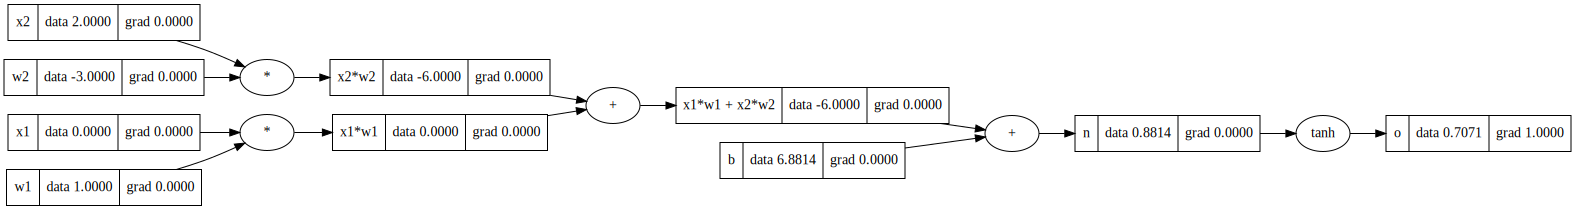

In [32]:
draw_dot(o)

Now, for do/dn we need to find the derivative through tanh
\
we know, 0 = tanh(n)
\
so what will be do/dn

&nbsp;

We'll refer the derivatives of tanh (3rd equation) \
![3rd equation](https://wikimedia.org/api/rest_v1/media/math/render/svg/5ce1bbbd6d77b52848c63b202dd42c227345fef3)

&nbsp;

We will use the first one in that, i.e. 1 - tan^2 x
\
So basically, \
=> o = tanh(n) \
=> do/dn = 1 - tanh(n) ** 2 \
=> do/dn = 1 - o ** 2

&nbsp;

Now this is broken down to a simpler equation which our Value object can perform.

In [33]:
1 - (o.data**2)

0.4999999999999999

So, it is coming to 0.5 approx

In [34]:
n.grad = 0.5

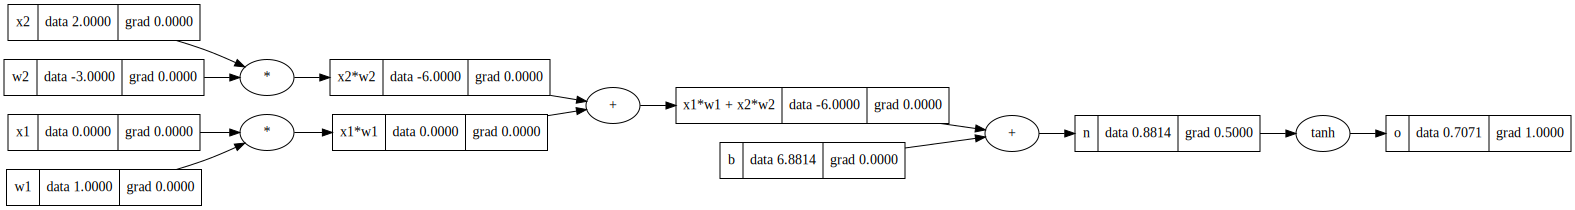

In [35]:
draw_dot(o)

Here, we know from previous example that, if it is an addition operation, then the derivative just comes as 1. So here the gradient value of n will itself channel out to its child nodes.

In [36]:
b.grad = 0.5
x1w1x2w2.grad = 0.5

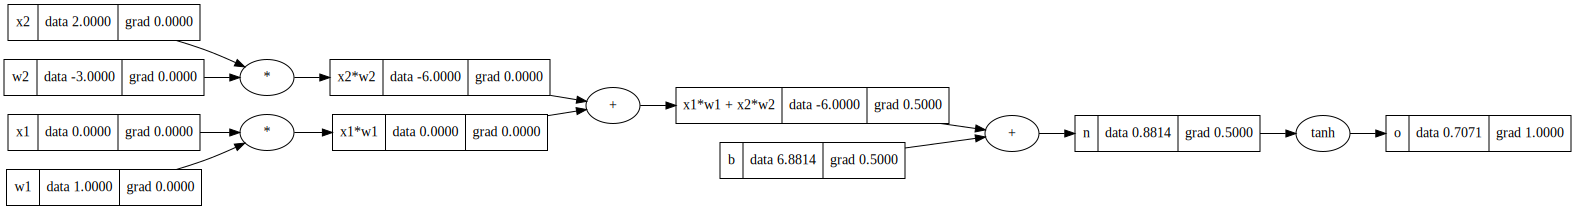

In [37]:
draw_dot(o)

Continuing, same we have the '+' operation again. So the grad value of x1w1x2w2 flows onto its child nodes

In [38]:
x1w1.grad = 0.5
x2w2.grad = 0.5

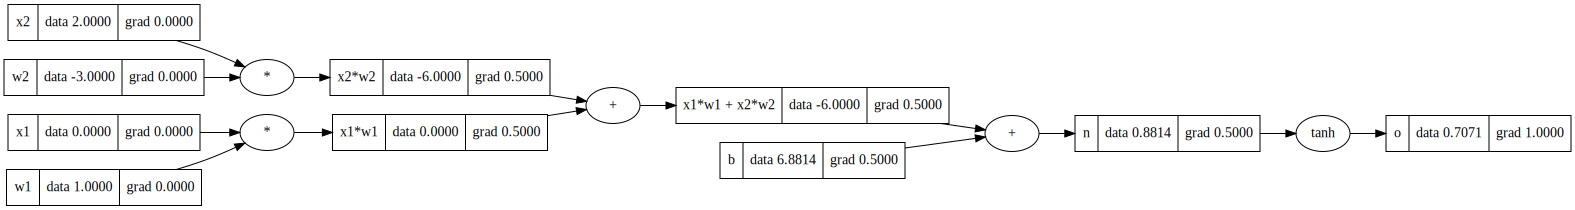

In [39]:
draw_dot(o)

Now, its the product '*' (We have already seen how it interchanges the values) \
So\
x1 = w1 * x1w1.grad => 1.0 * 0.5 = 0.5 \
w1 = x1 * x1w1.grad => 0.0 * 0.5 = 0.0

&nbsp;

x2 = w2 * x2w2.grad => -3.0 * 0.5 = -1.5\
w2 = x2 * x2w2.grad => 2.0 * 0.5 = 1.0

In [40]:
x1.grad = 0.5
w1.grad = 0.0
x2.grad = -1.5
w2.grad = 1.0

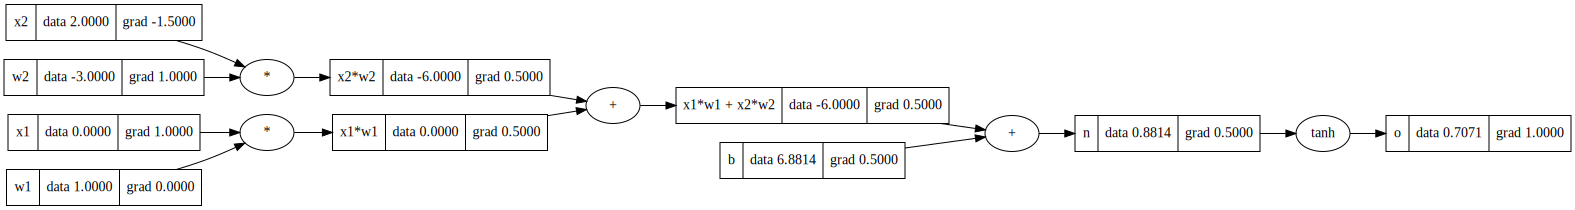

In [41]:
draw_dot(o)

*P.S. I have edited this file from my local system, I have modified the above cells to the correct value (x1.grad), so in the above node x1, the grad value should display 0.5 not 1.0*

-----------

**Now, here the weights play a huge rule in reducing the loss function value in the end. Therefore, he we can get to know by changing which 'w' we can affect the final output.** \
\
**In this case, w1 has no effect on this neuron's output, as it's gradient is 0** \
\
**So, in this example, only 'w2' has an effect.** \
\
Therefore, my modifying the value of 'w2' and increasing the bias, we can squash the tanh function and get the final output to flat out to 1.